# EMO task

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [1]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q
!pip install NRCLex -q
!pip install textblob -q
!python -m textblob.download_corpora -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

In [ ]:
EMO_json_path_train = f"{repo_path}{branch}/datasets/EMO22_lexicon_per_word_train.json"
EMP_json_path_train = f"{repo_path}{branch}/datasets/EMP22_lexicon_per_word_train.json"
EMO_json_path_dev = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_dev.json"
EMP_json_path_dev = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_dev.json"
EMO_json_path_test = f"{repo_path}{branch}/datasets/EMO23_lexicon_per_word_test.json"
EMP_json_path_test = f"{repo_path}{branch}/datasets/EMP23_lexicon_per_word_test.json"

!wget {EMO_json_path_train}
!wget {EMP_json_path_train}
!wget {EMO_json_path_dev}
!wget {EMP_json_path_dev}
!wget {EMO_json_path_test}
!wget {EMP_json_path_test}

In [4]:
import json
import torch
import string
from torch import nn
from torch.nn import BCEWithLogitsLoss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import BertPreTrainedModel, BertModel
from transformers import RobertaModel,RobertaPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple
from nrclex import NRCLex
import importlib
import sys
from torch.utils.data import Dataset
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [5]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Dataset

### WASSA dataset

In [155]:
class WASSADataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        essay_id,
        targets,
        EMP_lexicon = None,
        EMO_lexicon = None,
        global_features = None,
        local_emotions = False,
        local_empathy = False,
        local_distress = False,

        max_len=None
        ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.essay = essay
        self.essay_id = essay_id
        self.targets = targets
        self.EMP_lexicon = EMP_lexicon
        self.EMO_lexicon = EMO_lexicon

        self.global_features = global_features
        self.local_emotions = local_emotions
        self.local_empathy = local_empathy
        self.local_distress = local_distress

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])

        essay_id = self.essay_id[index]

        inputs = self.tokenizer.encode_plus(
            text=essay,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }

        if self.targets is not None:
          item['labels'] = torch.FloatTensor(self.targets[index])

        if self.global_features is not None:
          item['global_features'] = self.global_features[index]

        NRC_emotions = ['fear','anger','anticip','trust', 'surprise', 'positive',
                        'negative','sadness', 'disgust', 'joy', 'hope']
        n_local_features = 0
        if self.local_emotions: n_local_features += len(NRC_emotions)
        if self.local_empathy: n_local_features += 1
        if self.local_distress: n_local_features += 1

        if n_local_features > 0:
          features_tokens = np.zeros((self.tokenizer.model_max_length, n_local_features))
        else:
          features_tokens = None

        word_count=0
        first_char=True
        last_char_is_space=False
        for char_idx, char in enumerate(essay):
          token_idx = inputs.char_to_token(char_idx)
          if token_idx is None and not first_char:
            if not last_char_is_space:
              word_count+=1
              last_char_is_space=True
            continue
          elif last_char_is_space:
            last_char_is_space=False
          first_char=False

          j = 0

          if char not in string.punctuation:
            try:
              if self.local_emotions:
                for i, emo in enumerate(NRC_emotions):

                  features_tokens[token_idx][i] = self.EMO_lexicon[str(essay_id)][emo][word_count]

                j += len(NRC_emotions)

              if self.local_empathy:

                features_tokens[token_idx][j] = self.EMP_lexicon[str(essay_id)]['empathy'][word_count]
            except IndexError:
              print(len(self.EMO_lexicon[str(essay_id)][emo]))
              print(len(self.EMP_lexicon[str(essay_id)]['empathy']))
              print(len(essay.split()))

              j +=1
            if self.local_distress:
              features_tokens[token_idx][j] = self.EMP_lexicon[str(essay_id)]['distress'][word_count]

        item['local_features'] = torch.FloatTensor(features_tokens)

        return item

Dataset paths

In [6]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA22_essay_level_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA22_essay_level_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets_prec/WASSA23_essay_level_dev_preproc.tsv"

Read dataframes

In [7]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

Optional subsample

In [ ]:
train_df = train_df[:10]
val_df = val_df[:10]
dev_df = dev_df[:10]

Encode targets

In [8]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [9]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['hope'] will be ignored
  warnings.warn(


In [9]:
#@title Global Features
emo_count_global = True #@param {type:"boolean"}
empathy_count_global = True #@param {type:"boolean"}
distress_count_global = True #@param {type:"boolean"}
bio_global = True #@param {type:"boolean"}
global_features_names = []
emotions_count = ['fear_count',	'anger_count','anticip_count',	'trust_count',
                 'positive_count',	'negative_count', 'surprise_count',
                 'sadness_count',	'disgust_count',	'joy_count',	'hope_count']
bio = ['gender', 'age', 'income', 'race', 'education']
if emo_count_global:
  for emo in emotions_count: global_features_names.append(emo)
if empathy_count_global: global_features_names.append('empathy')
if distress_count_global: global_features_names.append('distress')
if bio_global:
  for b in bio: global_features_names.append(b)


In [8]:
#@title Local Features
emo_count_local = True #@param {type:"boolean"}
empathy_count_local = True #@param {type:"boolean"}
distress_count_local = True #@param {type:"boolean"}

local_features_names = []
if emo_count_local: local_features_names.append('emotions')
if empathy_count_local: local_features_names.append('empathy')
if distress_count_local: local_features_names.append('distress')



In [11]:
#@title Number of labels
num_labels = 8 #@param {type:"number"}


In [12]:
NUM_LABELS = num_labels
GLOBAL_FEATURES_NAMES = global_features_names
LOCAL_FEATURES_NAMES = local_features_names
DIM_EXTRA_FEATURES_GLOBAL = len(GLOBAL_FEATURES_NAMES)

Extra global features

In [ ]:
features_train =  np.array(train_df[GLOBAL_FEATURES_NAMES])
features_val =  np.array(val_df[GLOBAL_FEATURES_NAMES])
features_dev =  np.array(dev_df[GLOBAL_FEATURES_NAMES])

## Lexicons

In [ ]:
with open("/content/EMO22_lexicon_per_word_train.json") as json_file:
  EMO_lexicon_train_dict = json.load(json_file)
with open("/content/EMP22_lexicon_per_word_train.json") as json_file:
  EMP_lexicon_train_dict = json.load(json_file)

with open("/content/EMO23_lexicon_per_word_dev.json") as json_file:
  EMO_lexicon_dev_dict = json.load(json_file)
with open("/content/EMP23_lexicon_per_word_dev.json") as json_file:
  EMP_lexicon_dev_dict = json.load(json_file)
with open("/content/EMO23_lexicon_per_word_test.json") as json_file:
  EMO_lexicon_test_dict = json.load(json_file)
with open("/content/EMP23_lexicon_per_word_test.json") as json_file:
  EMP_lexicon_test_dict = json.load(json_file)

## Model

In [11]:
model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'bert-base':'bert-base-cased',
  'roberta-base' : 'roberta-base'
}

In [ ]:
model_config = {
    'model_id': 'roberta_lexicon',
    'tokenizer_name': model_type.get('roberta-base'),
    'model_name': model_type.get('roberta-base'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0,
    'weighted_loss': True
}

In [174]:
def get_loss_weights(y):
  inverse_n_samples = 1 / np.sum(y, axis=0)
  sum_inverses = sum(inverse_n_samples)
  weights_train = inverse_n_samples / sum_inverses
  return torch.cuda.FloatTensor(weights_train)

In [175]:
if model_config.get('weighted_loss'):
  loss_weights_train = get_loss_weights(y_train)


In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

### Custom "lexicon" model

In [147]:
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims, local_features_name, loss_weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        self.local_features_name = local_features_name
        self.loss_weights = loss_weights
        # Initialize weights and apply final processing
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,


        local_features = None,
        global_features = None,

        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )


        sequence_output = outputs[0]
        output = sequence_output[:, 0, :]

        if local_features is not None:
          output = outputs.last_hidden_state

          output = torch.cat((
                  output,
                  local_features.reshape(outputs.last_hidden_state.shape[0], outputs.last_hidden_state.shape[1], -1)),
                             dim=2)

          mask = torch.zeros_like(attention_mask)
          # unmask cls token
          mask[:,0] = 1.0
          print(self.local_features_name)
          # unmask tokens with high or low empathy, high distress levels, or expressing at least one emotion
          j = 0
          if 'emotions' in self.local_features_name:
            emotion_values = local_features[:,:,:11]
            mask[emotion_values.sum(dim=-1)>=1] = 1.0
            print(mask)
            j += 11

          if 'empathy' in self.local_features_name:
            empathy_values = local_features[:,:,j]
            mask[(empathy_values>5) | ((empathy_values<3) & (empathy_values>=1))] = 1.0
            print(mask)
            j += 1

          if 'distress' in self.local_features_name:
            distress_values = local_features[:,:,j]
            mask[distress_values>4] = 1.0
            print(mask)

          print(mask)
          print(mask.shape)
          # mean pooling of unmasked tokens
          output = outputs.last_hidden_state

          input_mask_expanded = mask.unsqueeze(-1).expand(output.size()).float()
          sum_embeddings = torch.sum(output * input_mask_expanded, 1)
          sum_mask = input_mask_expanded.sum(1)
          sum_mask = torch.clamp(sum_mask, min = 1e-9)
          pooled_output = sum_embeddings/sum_mask

          input_mask_expanded = attention_mask.unsqueeze(-1).expand(output.size()).float()
          sum_embeddings = torch.sum(output * input_mask_expanded, 1)
          sum_mask = input_mask_expanded.sum(1)
          sum_mask = torch.clamp(sum_mask, min = 1e-9)
          output = sum_embeddings/sum_mask


        if global_features is not None: #global
          output = torch.cat((output, global_features), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss(weight = self.loss_weights)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss(weight = self.loss_weights)
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [176]:
model = CustomSequenceClassification.from_pretrained(model_config.get("model_name"),
                                                     num_labels=NUM_LABELS,
                                                     classifier_dropout=0.1,
                                                     num_extra_dims = DIM_EXTRA_FEATURES_GLOBAL,
                                                     local_features_name = LOCAL_FEATURES_NAMES,
                                                     loss_weights = loss_weights_train
                                                     )

Some weights of the model checkpoint at roberta-base were not used when initializing CustomSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing CustomSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'classifier.out_proj.weight', 'roberta.pooler.dense.bias', 'classifier.dense.bias', 'classifier.out_proj.bia

## Training

Prepare datasets

In [112]:
train_set = WASSADataset(tokenizer=tokenizer,
                       EMO_lexicon=EMO_lexicon_train_dict,
                       EMP_lexicon=EMP_lexicon_train_dict,
                       essay=train_df.essay,
                       essay_id = train_df.essay_id,
                       targets=y_train,
                       global_features = features_train,
                       local_emotions = True,
                       local_empathy = True,
                       local_distress = True)

val_set = WASSADataset(tokenizer=tokenizer,
                     EMO_lexicon=EMO_lexicon_train_dict,
                     EMP_lexicon=EMP_lexicon_train_dict,
                     essay=val_df.essay,
                     essay_id = val_df.essay_id,targets=y_val,
                     global_features = features_val,
                     local_emotions = True,
                     local_empathy = True,
                     local_distress = True)

Set up training

In [21]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 300,
    save_steps = 300,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [177]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [ ]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))

trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [ ]:
trainer.train()

In [57]:
len(EMO_lexicon_train_dict["4"]['fear'])

145

In [198]:
len(EMP_lexicon_train_dict["4"]['empathy'])

149

In [ ]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
train_epochs = [log.get('epoch') for log in train_logs if log.get('loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_logs

In [ ]:
plot_loss_curve(train_loss_values, eval_loss_values, loss_epochs, eval_epochs,"loss", f"{model_config['model_name']}_loss.png")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'loss_epochs' is not defined

## Evaluation

In [ ]:
def predict_emotions(results, gold_emotions):

  binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)

  for i, bin_pred in enumerate(binarized_predictions):
    if np.all(bin_pred==0):
      binarized_predictions[i][np.argmax(results.predictions[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [ ]:
trainer.state.best_model_checkpoint

'./roberta-base/checkpoint-600'

In [ ]:
outs = trainer.predict(dev_set)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
gold_emotions = gold_emotions = label_encoder.decode(outs.label_ids)
predicted_emotions = predict_emotions(outs, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.565,
 'micro_precision': 0.6683,
 'micro_f': 0.6123,
 'macro_recall': 0.2298,
 'macro_precision': 0.227,
 'macro_F': 0.2073,
 'accuracy': 0.4413}

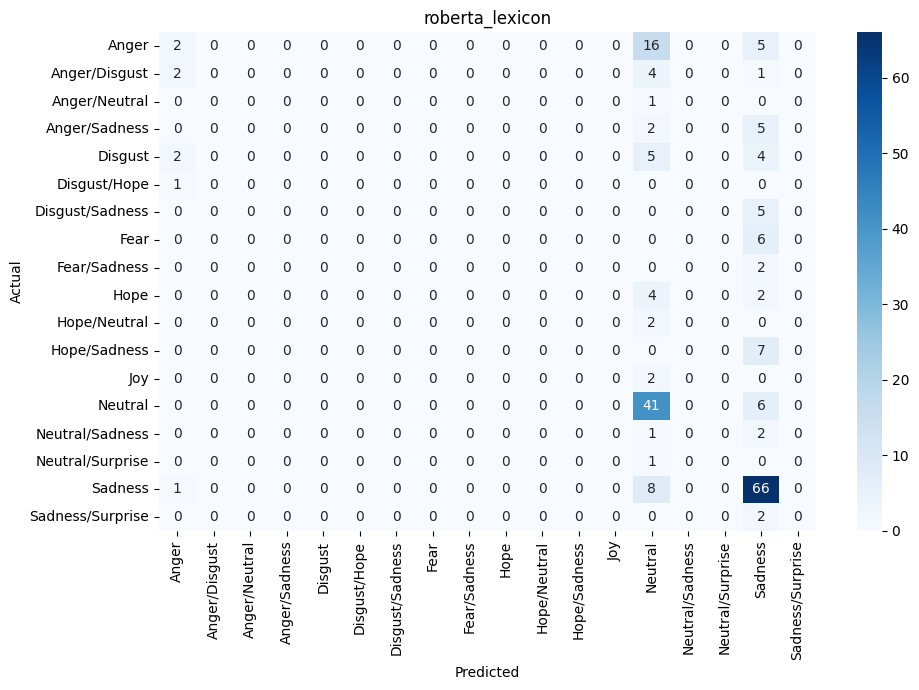

In [ ]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

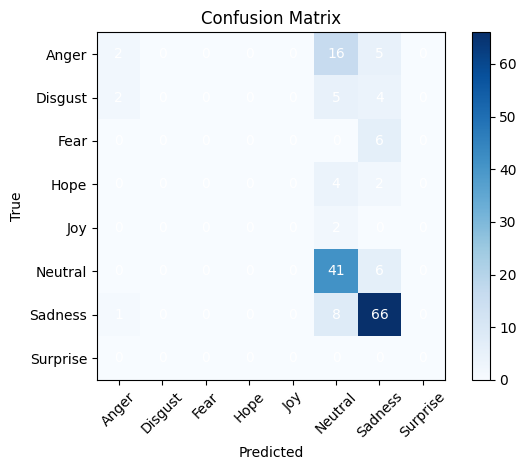

In [ ]:
# Define the desired label names
label_names = ['Anger', 'Disgust', 'Fear', 'Hope', 'Joy', 'Neutral', 'Sadness', 'Surprise']

# Compute the confusion matrix
cm = confusion_matrix(gold_emotions, predicted_emotions, labels=label_names)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Add numbers in each cell
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /content/utils.py:40 in plot_model_graph                                                         │
│                                                                                                  │
│    37 │   :param input_data: input data to the model                                             │
│    38 │   :param path: path where to save the graph (no need to specify the extension)           │
│    39 │   '''                                                                                    │
│ ❱  40 │   model_graph = draw_graph(model, input_data=input_data)                                 │
│    41 │   model_graph.visual_graph.render(filename=path)                                         │
│    42 │   model_graph.visual_graph.view()                                                        │
│    43                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'draw_graph' is not defined

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1980'

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

load checkpoint

In [ ]:
# Load the checkpoint file
checkpoint_file = "/content/roberta-base/checkpoint-1200"
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
model = CustomSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS, num_extra_dims = 10)
trainer = Trainer(model=model)
# Perform prediction using the loaded checkpoint
predictions = trainer.predict(dev_set)

In [ ]:
gold_emotions = label_encoder.decode(predictions.label_ids)
predicted_emotions = predict_emotions(predictions, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.6504,
 'micro_precision': 0.7407,
 'micro_f': 0.6926,
 'macro_recall': 0.3772,
 'macro_precision': 0.4272,
 'macro_F': 0.3945,
 'accuracy': 0.5298}